# Redlining Queens, NY analysis 

In [2]:
# Import all of the packages
import os # Interoperable file paths
import pathlib # Find the home folder
import geopandas as gpd # Work with vector data
import hvplot.pandas # Interactive plots of vector data
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob # Find files by pattern
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
import cartopy.crs as ccrs # CRSs
import hvplot.xarray # Interactive raster
import xarray as xr # Adjust images
import pandas as pd # Ordered categorical data
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import earthaccess # Access NASA data from the cloud
from rioxarray.merge import merge_arrays # Merge rasters

c:\Users\anpo9052\AppData\Local\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Create project directory
data_dir = os.path.join(pathlib.Path.home(),
                        'earth-analytics',
                        'data',
                        'redlining')
os.makedirs(data_dir, exist_ok=True)

In [6]:
# Define info for redlining download
redlining_url = (
    "https://dsl.richmond.edu/panorama/redlining/static"
    "/mappinginequality.gpkg"
)
redlining_dir = os.path.join(data_dir, 'redlining')
os.makedirs(redlining_dir, exist_ok=True)
redlining_path = os.path.join(redlining_dir, 'redlining.shp')

# Only download once
if not os.path.exists(redlining_path):
    redlining_gdf = gpd.read_file(redlining_url)
    redlining_gdf.to_file(redlining_path)

# Load from file
redlining_gdf = gpd.read_file(redlining_path)

c:\Users\anpo9052\AppData\Local\miniconda3\envs\earth-analytics-python\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\anpo9052\earth-analytics\data\redlining\redlining\redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [7]:
queens_redlining_gdf = redlining_gdf[redlining_gdf.city=='Queens']
queens_redlining_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Queens, NY',
    fill_color=None, line_color='darkorange', line_width=3,
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [3]:
earthaccess.login(strategy="interactive", persist=True)

In [8]:
queens_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(queens_redlining_gdf.total_bounds),
    temporal=("2023-08-31"),
    count=1
)
queens_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -73.6725431, 'Latitude': 40.55512308}, {'Longitude': -73.33575274, 'Latitude': 41.53980024}, {'Longitude': -73.80103039, 'Latitude': 41.54559377}, {'Longitude': -73.81885207, 'Latitude': 40.55671174}, {'Longitude': -73.6725431, 'Latitude': 40.55512308}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-09-01T15:39:27.955Z', 'EndingDateTime': '2023-09-01T15:39:51.842Z'}}
 Size(MB): 43.258413314819336
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TXL.2023244T153927.v2.0/HLS.L30.T18TXL.2023244T153927.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T18TXL.2023244T153927.v2.0/HLS.L30.T18TXL.2023244T153927.v2.0.B04.tif', 'https://data.lpd

In [9]:
queens_files=earthaccess.open(queens_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Connect ot the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()
    
    #Get the study bounds
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
    )
    
    #Crop
    cropped_da = da.rio.clip_box(*bounds)
    
    return cropped_da

In [12]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    # Open fmask file 
    fmask_da = process_image(cloud_uri, bounds_gdf)
    
    #Unpack the cloud mask bits 
    cloud_bits = (
      np.unpackbits(
        (
            # Get the cloud mask as an array...
            fmask_da.values
            # ... of 8-bit integers
            .astype('uint8')
            # With an extra axis to unpack the bits into
            [:, :, np.newaxis]
        ), 
        # List the least significat bit first to match the user guide
        bitorder='little',
        # Expand the array in a new dimension
        axis=-1))

# And add up the bits for each pixel
    cloud_mask = np.sum(
    # Select bits 
      cloud_bits[:,:,bits_to_mask], 
    # Sum along the bit axis
      axis=-1
    #Check if nay of the bits are true
    ) == 0

    return cloud_mask

In [13]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\."
    r"(?P<band_id>.+)\.tif"   
)

# Find all the metadata in the file name
uri_groups = [
    uri_re.search(queens_file.full_name).groupdict()
    for queens_file in queens_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = queens_files

# Check the results
raster_df

,tile_id,date,band_id,file
0,T18TXL,2023244,B01,"<File-like object HTTPFileSystem, https://data..."
1,T18TXL,2023244,B04,"<File-like object HTTPFileSystem, https://data..."
2,T18TXL,2023244,B11,"<File-like object HTTPFileSystem, https://data..."
3,T18TXL,2023244,B02,"<File-like object HTTPFileSystem, https://data..."
4,T18TXL,2023244,VZA,"<File-like object HTTPFileSystem, https://data..."
5,T18TXL,2023244,VAA,"<File-like object HTTPFileSystem, https://data..."
6,T18TXL,2023244,B10,"<File-like object HTTPFileSystem, https://data..."
7,T18TXL,2023244,B03,"<File-like object HTTPFileSystem, https://data..."
8,T18TXL,2023244,B06,"<File-like object HTTPFileSystem, https://data..."
9,T18TXL,2023244,SAA,"<File-like object HTTPFileSystem, https://data..."


In [14]:
# Labels for each band to process
bands = {
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir'
}
# Initialize structure for saving images
queens_das = {band_name: [] for band_name in bands.values()}
for tile_id, tile_df in raster_df.groupby('tile_id'):
    # Load the cloud mask
    fmask_file = tile_df[tile_df.band_id == 'Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file,
        queens_redlining_gdf,
        [1, 2, 3, 5])
    
    
    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            # Process band
            band_da = process_image(row.file.values[0], queens_redlining_gdf)
            # Mask band
            band_masked_da = band_da.where(cloud_mask)
            # Store the resulting DataArray ofr later
            queens_das[band_name].append(band_masked_da)

queens_das

C:\Users\anpo9052\AppData\Local\Temp\ipykernel_17460\2457378720.py:29: RuntimeWarning: invalid value encountered in cast
  .astype('uint8')


{'red': [<xarray.DataArray (y: 872, x: 326)> Size: 1MB
  array([[   nan,    nan,    nan, ..., 0.035 , 0.0359, 0.0397],
         [   nan,    nan,    nan, ..., 0.04  , 0.0437, 0.045 ],
         [   nan,    nan,    nan, ..., 0.0286, 0.0431, 0.0457],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]],
        dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 3kB 6e+05 6e+05 6.001e+05 ... 6.097e+05 6.098e+05
    * y            (y) float64 7kB 4.517e+06 4.517e+06 ... 4.491e+06 4.491e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave_xshift(meters):   0, 0
      arop_ave_yshift(meters):   0, 0
      arop_ncp:                  0, 0
      arop_rmse(meters):         0, 0
      arop_s2_refimg:            NONE
      ...                     

In [15]:
# Merge all tiles
queens_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in queens_das.items()}

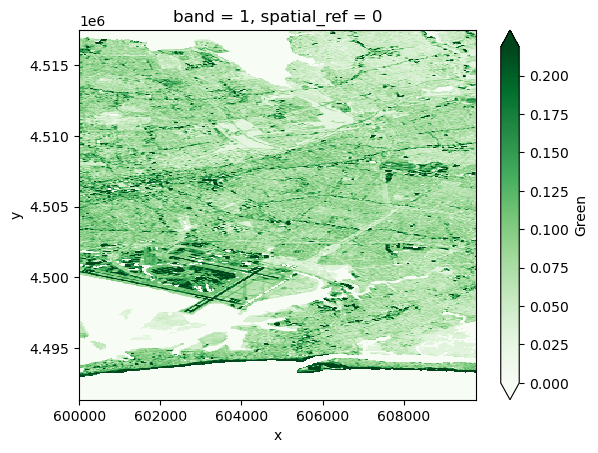

In [18]:
# Plot a merged raster band
queens_merged_das['green'].plot(cmap='Greens', robust=True)

In [21]:
# Calculate Normalized Difference Vegetation Index (NDVI)

queens_ndvi = (
    (queens_merged_das['nir'].values - queens_merged_das['red'].values)
    / (queens_merged_das['nir'].values + queens_merged_das['red'].values)
)

coords= {
    'latitude': queens_merged_das['red'].coords['y'].values,
    'longitude': queens_merged_das['red'].coords['x'].values
}

queens_ndvi_da = xr.DataArray(queens_ndvi, coords)

queens_ndvi_da

C:\Users\anpo9052\AppData\Local\Temp\ipykernel_17460\3650838194.py:4: RuntimeWarning: invalid value encountered in divide
  (queens_merged_das['nir'].values - queens_merged_das['red'].values)


<xarray.DataArray (latitude: 872, longitude: 326)> Size: 1MB
array([[       nan,        nan,        nan, ..., 0.6964441 , 0.72213626,
        0.72630125],
       [       nan,        nan,        nan, ..., 0.696625  , 0.6827586 ,
        0.6670366 ],
       [       nan,        nan,        nan, ..., 0.76528513, 0.69236255,
        0.6612305 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 7kB 4.517e+06 4.517e+06 ... 4.491e+06
  * longitude  (longitude) float64 3kB 6e+05 6e+05 ... 6.097e+05 6.098e+05

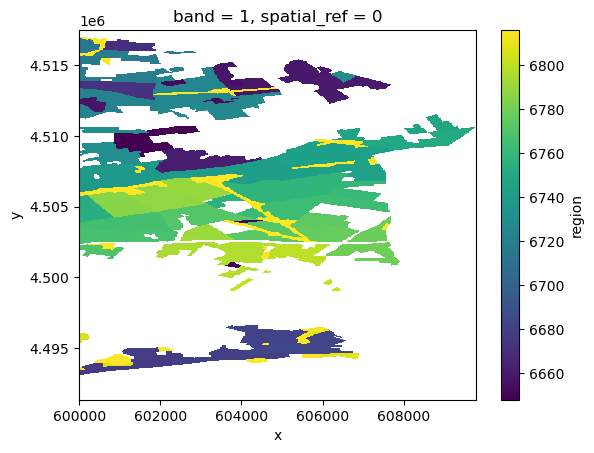

In [25]:
# Obtain mask for zones
queens_redlining_mask = regionmask.mask_geopandas(
    queens_redlining_gdf.to_crs(queens_merged_das['red'].rio.crs), 
    queens_merged_das['red'].x, # meters
    queens_merged_das['red'].y, # meters 
    # The regions do not overlap bc no lat/long coords
    overlap=False,
    # We're not using geographic coordinates
    wrap_lon=False
)

queens_redlining_mask.plot()

In [26]:
# Calculate NDVI stats for each redlining zone
queens_ndvi_stats = zonal_stats(zones= queens_redlining_mask, values= queens_ndvi_da)

In [69]:
# Merge the NDVI stats with redlining geometry into one `GeoDataFrame`
queens_ndvi_gdf = queens_redlining_gdf.merge(
    queens_ndvi_stats.set_index('zone'),
    left_index=True,
    right_index=True
)
# Change grade to ordered Categorical for plotting
queens_ndvi_gdf.grade = pd.Categorical(
    queens_ndvi_gdf.grade,
    ordered=True,
    categories=['A', 'B', 'C', 'D']
)

# Drop rows with NA grades
queens_ndvi_gdf = queens_ndvi_gdf.dropna()

# Plot NDVI and redlining grade in linked subplots
fig1 = (
    queens_ndvi_gdf.hvplot(
        title='NDVI',
        c='mean',
        geo=True,
        cmap='Greens',
        frame_height=300,
        frame_width=400
    )
    +
    queens_ndvi_gdf.hvplot(
        title='Redlining grades',
        c='grade',
        geo=True,
        cmap='Blues',
        frame_height=300,
        frame_width=400
    )
)
hvplot.save(fig1, 'fig1.html')
fig1

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

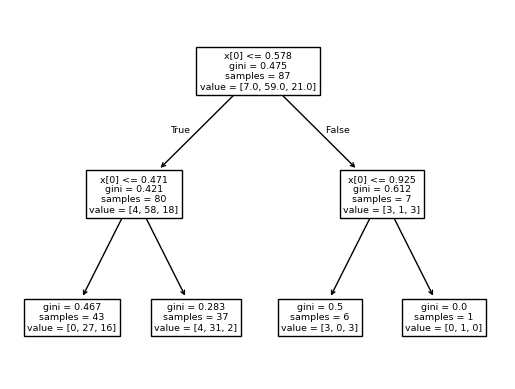

In [72]:
#Modeling
# Convert categories to numbers
queens_ndvi_gdf['grade_codes'] = queens_ndvi_gdf.grade.cat.codes

# Fit model
tree_classifier = DecisionTreeClassifier(max_depth=2).fit(
    queens_ndvi_gdf[['mean']],
    queens_ndvi_gdf.grade_codes
) #optimal depth from exercise done in class 

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [74]:
queens_ndvi_gdf['predictions']= (
    tree_classifier.predict(queens_ndvi_gdf[['mean']]))

queens_ndvi_gdf['error']= (
    queens_ndvi_gdf['predictions'] -
    queens_ndvi_gdf['grade_codes']
)

fig2 = (queens_ndvi_gdf.hvplot(c='predictions',title='Model Predictions of Grade',frame_width=400,
    frame_height=500, geo=True, cmap='summer') 
+
queens_ndvi_gdf.hvplot(c='error',title='Grade Prediction Error',frame_width=400,
    frame_height=500, geo=True, cmap='bwr').opts(clim=(-2,2)))

hvplot.save(fig2, 'fig2.html')
fig2

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (predictions)
   .Polygons.II :Polygons   [Longitude,Latitude]   (error)

In [47]:
queens_ndvi_gdf['predictions']

6657.0    2
6658.0    2
6659.0    1
6660.0    1
6661.0    1
         ..
6804.0    2
6806.0    2
6807.0    2
6808.0    2
6809.0    2
Name: predictions, Length: 87, dtype: int8

In [41]:
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=2),
    queens_ndvi_gdf[['mean']],
    queens_ndvi_gdf['grade_codes'],
    cv=3
)

array([0.65517241, 0.65517241, 0.68965517])